# Regularized Regression Project

Build a Ridge, Lasso, and ElasticNet models that predict the `price` column in the dataset on San Francisco Apartment rentals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("../Data/sf_clean.csv") #.query("price <= 6000")

rentals_df.head()

/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [2]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA

The 'hood_district' feature was read in as an integer but is really a categorical feature. Let's fix that.

In [3]:
rentals_df.hood_district = rentals_df.hood_district.astype('object')
rentals_df.dtypes

price              int64
sqft             float64
beds             float64
bath             float64
laundry           object
pets              object
housing_type      object
parking           object
hood_district     object
dtype: object

In [4]:
rentals_df.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


* Based on the range of prices above, we may need to subset our data based on some value to predict more "realistic" apartments. Possibly subset based on square-footage.
* When we see our 75th percentile has 2 bedrooms, but our max has 6, there's probably an outlier or two in this data, but we might be able to get away with leaving those in our data set.

/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='price', ylabel='Count'>

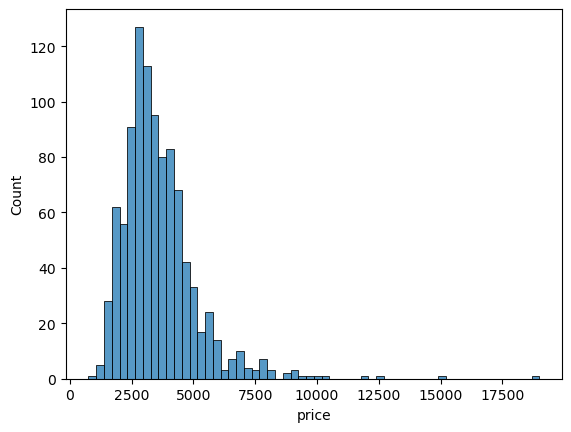

In [5]:
sns.histplot(rentals_df, x='price')

There are some very rare, expensive apartments that cost over 10k. This also kind of confirms that there are a few outliers in terms of price.

<AxesSubplot:>

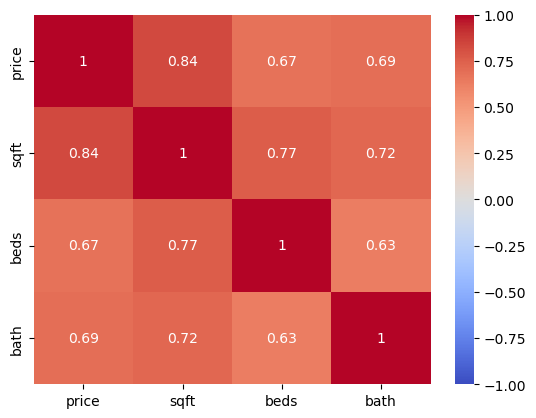

In [6]:
sns.heatmap(
    rentals_df.corr(numeric_only=True),
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
)

* Square foot variable is our strongest feature and that makes sense. We're mostly paying for space, so the size of an apartment should have a very strong relationship with the price.
* It's good to see that we have some strong correlations with our target here though. 
* Most of our numeric features are positively correlated with each other, could cause problems. That makes sense because larger apartments are going to have more bedrooms and four bathrooms on average than smaller apartments. SO we're raising a flag that we might have collinearity issues, but maybe we'll get lucky.

/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

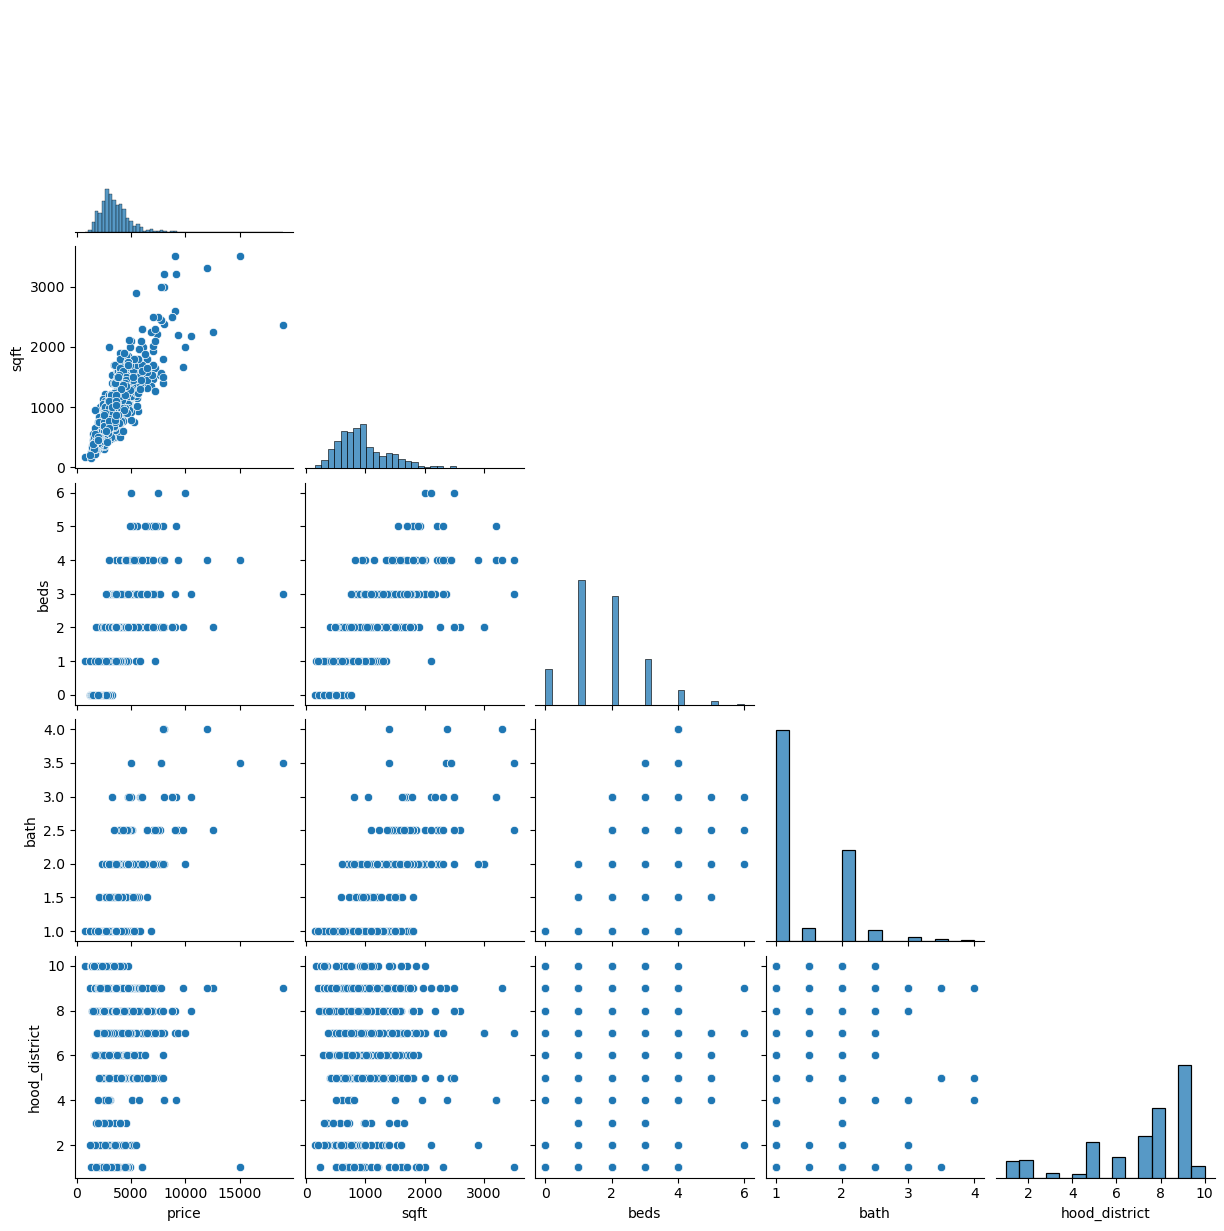

In [7]:
sns.pairplot(rentals_df, corner=True)

* Beautiful relationship between price and square footage, this is almost perfectly linear.
* Based on the pairplot above, we may be able to slice off the most expensive aparments by subsetting to only aparments <2500 sqft.
* One thing that surprised me a little bit was even though I cast my Hood district variable as object, it still got plotted by pair plot. So pair plot must have detected that it was numeric enough, but we don't really see much of a relationship here.

In [8]:
# Let's check the frequency of our categorical features

def value_counter(dataframe):
    value_series = pd.DataFrame()
    for col in dataframe.select_dtypes(['object']).columns:
        print(dataframe[col].value_counts())
        
value_counter(rentals_df)

laundry
(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64
pets
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64
housing_type
(c) multi     937
(a) single     40
(b) double     12
Name: count, dtype: int64
parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: count, dtype: int64
hood_district
9.0     332
8.0     207
7.0     123
5.0     106
6.0      62
2.0      51
1.0      50
10.0     33
3.0      14
4.0      11
Name: count, dtype: int64


Moving on to our categorical features, we have some rare categories that may need to be binned together.

We should consider:

1. Pets: Bin 'dogs', and 'both' into a 'dogs' 'allows_dogs' category.
2. Housing_type: Group 'multi' and 'double' together
3. Parking: Group 'protected', 'off-street', and 'valet' together
4. We should bin some of our lower count neighbhoords with neighboring ones. Let's look at average pricing for each and see which are related based on price.

/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


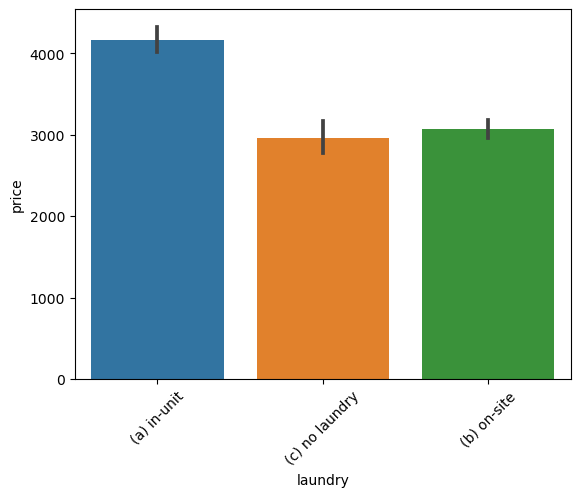

/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


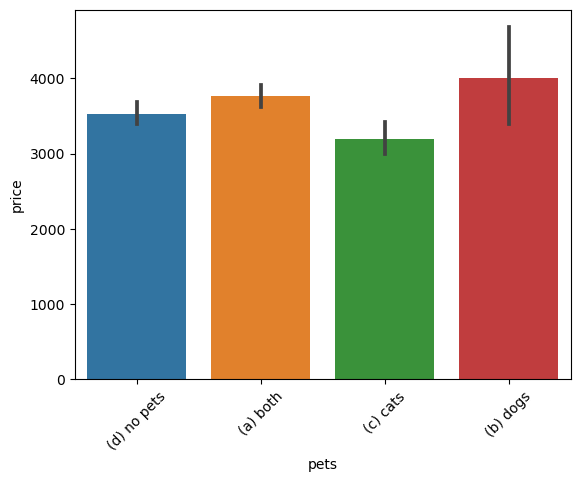

/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


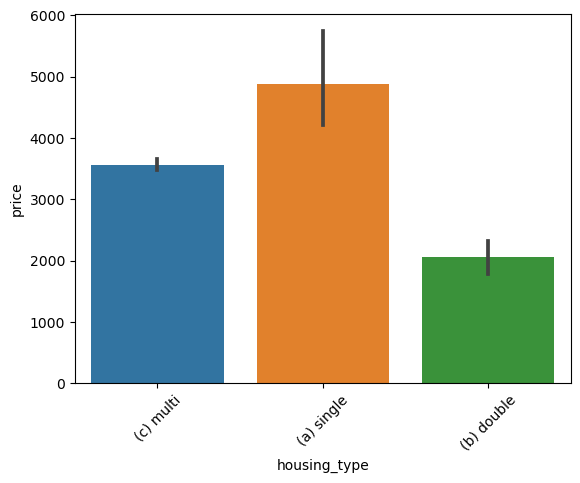

/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


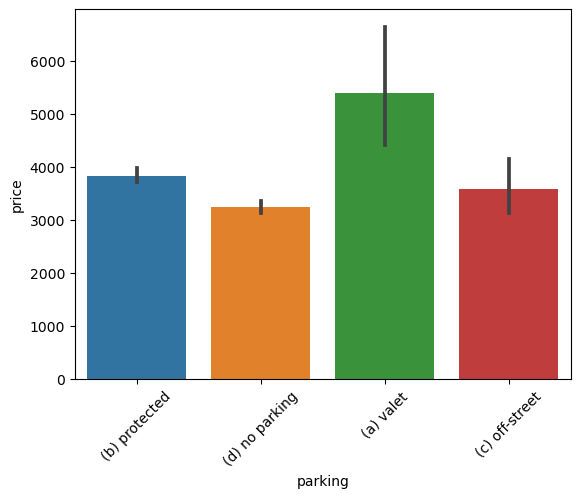

/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nadyavoynich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


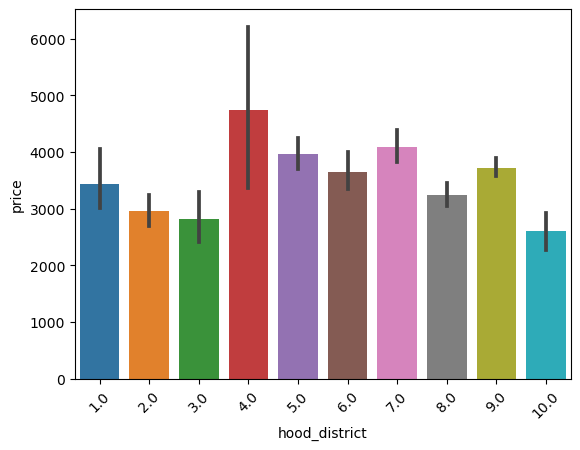

In [9]:
def cat_plotter(data, target):
    for col in data.select_dtypes(['object']).columns:
        sns.barplot(data=data, x=col, y=target)
        plt.xticks(rotation=45)
        plt.show()

cat_plotter(rentals_df, 'price')

* If the **laundry** is in the unit, so we have a washing machine inside our apartment, those tend to command a significant premium over those with no laundry or a shared facility. Because San Francisco is so dense, oftentimes on site, laundry is just about as close as in unit because there might be a laundromat on every block. So this might also indicate a good opportunity to bend two features together to reduce model complexity.
* **Pets.** Dogs or both tend to be a little bit more expensive than no pets or cats.
* **Housing type** single family homes that stand alone are the most expensive, followed by apartments and then duplexes. But if we look again at our categories, we have very few single and double, so we'll probably need to bend double with this multi here.
* **Parking.** Valet not surprisingly is the most expensive and that's a massive premium. No parking is the cheapest which makes sense and then protected and off street. So this is either a parking lot specific to the apartment building or a garage are about the same price. We can probably bend off-street and protected together while leaving valet and no parking on their own.
* **Neighborhood feature**. Neighborhoods 4, 5, 6 and 7 are the most expensive. This northeast corner of the city is where most offices are. This is where most tech workers go to work. So this tends to be the more expensive part of the city as you move out to the west side and the south, we start to get to cheaper, more working class neighborhoods.

## Feature Engineering

In [10]:
# Group Categories together

laundry_map = {
    "(a) in-unit": "in_unit",
    "(b) on-site": "not_in_unit",
    "(c) no laundry": "not_in_unit",
}

pet_map = {
    "(a) both": "allows_dogs",
    "(b) dogs": "allows_dogs",
    "(c) cats": "no_dogs",
    "(d) no pets": "no_dogs"
}


housing_type_map = {
    "(a) single": "single",
    "(b) double": "multi",
    "(c) multi": "multi",
}

district_map = {
    1.0: "west",
    2.0: "southwest",
    3.0: "southwest",
    4.0: "central",
    5.0: "central",
    6.0: "central",
    7.0: "marina",
    8.0: "north beach",
    9.0: "FiDi/SOMA",
    10.0: "southwest"
    
}

In [23]:
eng_df = rentals_df.assign(
#    hood_district = rentals_df["hood_district"].map(district_map),
#    housing_type = rentals_df["housing_type"].map(housing_type_map),
#    pets = rentals_df["pets"].map(pet_map),
#    laundry = rentals_df["laundry"].map(laundry_map),
    sqft2 = rentals_df["sqft"] ** 2,
    sqft3 = rentals_df["sqft"] ** 3,
    beds2 = rentals_df["beds"] ** 2,
    beds3 = rentals_df["beds"] ** 3,
    bath2 = rentals_df["bath"] ** 2,
    bath3 = rentals_df["bath"] ** 3,
    beds_bath_ratio = rentals_df["beds"] / rentals_df["bath"]
)

eng_df = pd.get_dummies(eng_df, drop_first=True)

Some of the features that we saw that didn't improve our model earlier may if we use regularization.
* Let's get rid of the categorical binning and let regularization decide what's important.
* So we're adding cubic splines for all of our numeric features, adding our beds bath ratio, and we're going to go ahead and see how much more accuracy we can get by just fitting a machine learning model.

In [24]:
eng_df.head(3)

,price,sqft,beds,bath,sqft2,sqft3,beds2,beds3,bath2,bath3,...,parking_(d) no parking,hood_district_2.0,hood_district_3.0,hood_district_4.0,hood_district_5.0,hood_district_6.0,hood_district_7.0,hood_district_8.0,hood_district_9.0,hood_district_10.0
0,6800,1600.0,2.0,2.0,2560000.0,4.096000e+09,4.0,8.0,4.0,8.0,...,False,False,False,False,False,False,True,False,False,False
1,3500,550.0,1.0,1.0,302500.0,1.663750e+08,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
2,5100,1300.0,2.0,1.0,1690000.0,2.197000e+09,4.0,8.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False


In [25]:
# Convert boolean columns to int
bool_cols = [col for col in eng_df if eng_df[col].dtype == bool]
eng_df[bool_cols] = eng_df[bool_cols].astype(int)

In [26]:
eng_df.head(3)

,price,sqft,beds,bath,sqft2,sqft3,beds2,beds3,bath2,bath3,...,parking_(d) no parking,hood_district_2.0,hood_district_3.0,hood_district_4.0,hood_district_5.0,hood_district_6.0,hood_district_7.0,hood_district_8.0,hood_district_9.0,hood_district_10.0
0,6800,1600.0,2.0,2.0,2560000.0,4.096000e+09,4.0,8.0,4.0,8.0,...,0,0,0,0,0,0,1,0,0,0
1,3500,550.0,1.0,1.0,302500.0,1.663750e+08,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
2,5100,1300.0,2.0,1.0,1690000.0,2.197000e+09,4.0,8.0,1.0,1.0,...,1,0,0,0,0,0,1,0,0,0


## Data Splitting

In [27]:
from sklearn.model_selection import train_test_split

target = "price"
drop_cols = [
#     "pets_no_dogs",
#     "housing_type_single"
]

X = sm.add_constant(eng_df.drop([target] + drop_cols, axis=1))

# Log transform slightly improves normality
y = np.log(eng_df[target])
# y = eng_df[target]

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

## Scaling Data

In [28]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X.values)
X_te = std.transform(X_test.values)

## Ridge Regression

In [29]:
from sklearn.linear_model import RidgeCV

n_alphas = 100
alphas = 10 ** np.linspace(-3, 3, n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv=5)

ridge_model.fit(X_tr, y)
print(f"Cross Val R2: {ridge_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(ridge_model.predict(X_tr)))}")
print(f"Alpha: {ridge_model.alpha_}")

Cross Val R2: 0.8385931914517343
Cross Val MAE: 449.78809785100736
Alpha: 0.13219411484660287


In [30]:
list(zip(X.columns, ridge_model.coef_))

[('const', 0.0),
 ('sqft', 0.4277189661751064),
 ('beds', 0.08215303569600578),
 ('bath', 0.09371487268209734),
 ('sqft2', -0.3311229598293453),
 ('sqft3', 0.1133589335994661),
 ('beds2', -0.16543427825459514),
 ('beds3', 0.09181993991313993),
 ('bath2', -0.06537874836241545),
 ('bath3', 0.05833683738040214),
 ('beds_bath_ratio', 0.06102729477528141),
 ('laundry_(b) on-site', -0.038419760376629176),
 ('laundry_(c) no laundry', -0.029767131552482805),
 ('pets_(b) dogs', 0.0068374841793759225),
 ('pets_(c) cats', -0.0029892295960896203),
 ('pets_(d) no pets', -0.004706036634352227),
 ('housing_type_(b) double', -0.010757739645694145),
 ('housing_type_(c) multi', -0.002933378285989677),
 ('parking_(b) protected', -0.08372878097175604),
 ('parking_(c) off-street', -0.029978914464802886),
 ('parking_(d) no parking', -0.11016786659078974),
 ('hood_district_2.0', -0.00740287445225595),
 ('hood_district_3.0', -0.01009315613714276),
 ('hood_district_4.0', 0.0020652373159872704),
 ('hood_distric

## Lasso Regression

In [31]:
from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = 10 ** np.linspace(-2, 3, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv=5)

lasso_model.fit(X_tr, y)

print(f"Cross Val R2: {lasso_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(lasso_model.predict(X_tr)))}")
print(f"Alpha: {lasso_model.alpha_}")

Cross Val R2: 0.8129780229340178
Cross Val MAE: 490.47394723593777
Alpha: 0.01


In [32]:
list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('sqft', 0.20409896612931402),
 ('beds', 0.0),
 ('bath', 0.082656202673014),
 ('sqft2', -0.0),
 ('sqft3', -0.006974225557041219),
 ('beds2', -0.0),
 ('beds3', -0.0),
 ('bath2', 0.0),
 ('bath3', 0.0),
 ('beds_bath_ratio', 0.07600636348963835),
 ('laundry_(b) on-site', -0.04050115316796512),
 ('laundry_(c) no laundry', -0.029539680091455096),
 ('pets_(b) dogs', 0.000687343879004213),
 ('pets_(c) cats', -0.0),
 ('pets_(d) no pets', -0.0),
 ('housing_type_(b) double', -0.005332280277401444),
 ('housing_type_(c) multi', 0.0048754695015298),
 ('parking_(b) protected', -0.0),
 ('parking_(c) off-street', 0.0),
 ('parking_(d) no parking', -0.03361242231604271),
 ('hood_district_2.0', -0.012463294976319006),
 ('hood_district_3.0', -0.007325466046783176),
 ('hood_district_4.0', -0.0),
 ('hood_district_5.0', 0.004126237093391834),
 ('hood_district_6.0', 0.0008212092185279433),
 ('hood_district_7.0', 0.01971582033346211),
 ('hood_district_8.0', -0.002513009123186523),
 ('hood_dist

In [33]:
# print(mae(np.exp(y_test), np.exp(lasso_model.predict(X_te))))
# print(f"Test R2: {r2(y_test, lasso_model.predict(X_te))}")

We still end up with a very low level of regularization with 490 MAE. So at this point, our **Ridge** model is really blowing Lasso out of the water.

## ENET

In [34]:
from sklearn.linear_model import ElasticNetCV

alphas = 10 ** np.linspace(-2, 3, 200)
l1_ratios = np.linspace(.01, 1, 100)

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)

enet_model.fit(X_tr, y)

print(f"Cross Val R2: {enet_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(enet_model.predict(X_tr)))}")
print(f"Alpha: {enet_model.alpha_}")
print(f"L1_Ratio: {enet_model.l1_ratio_}")

Cross Val R2: 0.8346175733621186
Cross Val MAE: 457.36513834175764
Alpha: 0.01
L1_Ratio: 0.01


In our elastic net skewed heavily towards ridge regression as well in our ridge regression model had better performance. So **Ridge** is the clear winner here.

## Final Model Test

In [35]:
print(f"Test MAE: {mae(np.exp(y_test), np.exp(ridge_model.predict(X_te)))}")
print(f"Test R2: {r2(y_test, ridge_model.predict(X_te))}")

Test MAE: 422.24068172029445
Test R2: 0.7988883883318376


The final model score get an error of 422. So that's our best model to date.

If our goal is pure predictive accuracy, this is probably enough of an advantage for us to choose **Ridge** over any of our other models.